# Twitter US Airline Sentiment 

### Applying ULMFiT to classify the sentiment of tweets

In this notebook I will apply ***Universal language model fine-tuning for text classification*** (ULMFiT) to the Twitter US Airline Sentiment dataset that can be downloaded from [kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv). ULMFiT was developed at [fast.ai](https://www.fast.ai/) and [published](https://arxiv.org/abs/1801.06146) in 2018 by Jeremy Howard and Sebastian Ruder. The training process introduced in the paper marks a milestone in the use of transfer learning for NLP, inspired a lot of further research in that direction and is still today a powerful technique for text classification.

I will use the brand new fastai version 2 library, which is going to be officially release any day now. Fastai automatically imports most other libraries that I need so I only need to import the fastai text module and seaborn for visualization.

In [1]:
from fastai2.text.all import *
import seaborn as sns

## 1. Data

### Exploratory data analysis

Before jumping into the training process, I will spend some time exploring the dataset in order to understand what we are trying predict and which variables are available as predictors. First, I will define my path and import the data with pandas.

In [2]:
path = Path('/storage/USAirlineSent')
path.ls()

(#12) [Path('/storage/USAirlineSent/.kaggle'),Path('/storage/USAirlineSent/dls_lm.pkl'),Path('/storage/USAirlineSent/Tweets_final_aug.csv'),Path('/storage/USAirlineSent/others'),Path('/storage/USAirlineSent/.ipynb_checkpoints'),Path('/storage/USAirlineSent/ulmfit_approach.png'),Path('/storage/USAirlineSent/models'),Path('/storage/USAirlineSent/tweets_Data-Aug.ipynb'),Path('/storage/USAirlineSent/Tweets.csv'),Path('/storage/USAirlineSent/Tweets_cls.csv')...]

In [3]:
df = pd.read_csv('Tweets.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

I find the best way to get a first impression of a dataset is to call `df.info()`. The dataframe contains fourteen columns and has 14640 rows in total. Let's have a look at some rows of data.

In [5]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


By looking at the columns it becomes failry obvious that the goal is to predict `airline_sentiment` from `text`. Fortunately, these two columns don't have any missing values.

In [6]:
print(f'Missing values in airline sentiment: {df.airline_sentiment.isna().sum()}')
print(f'Missing values in text: {df.text.isna().sum()}')

Missing values in airline sentiment: 0
Missing values in text: 0


Let's see how many classes we are trying to predict, because sentiment classification use cases range from binary (negative-positive) to 5 or even 10 class prediction problems.

In [7]:
print(f'Airline sentiment has {df.airline_sentiment.nunique()} classes: {df.airline_sentiment.unique()}')

Airline sentiment has 3 classes: ['neutral' 'positive' 'negative']


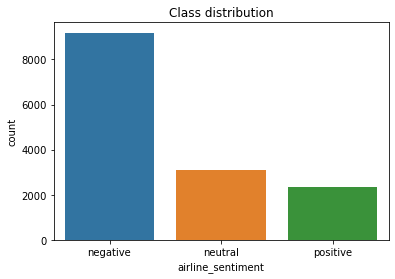

In [8]:
sns.countplot(x='airline_sentiment', data=df, order=['negative','neutral','positive']).set_title('Class distribution');

As in many practical sentiment classification problems, the number of negative examples is much larger then neutral or positive examples. This makes sense, since most people tend to complain about bad experiences rather then neutrally or positively describing their flights on twitter. Unfortunately, class imbalances are a problem for machine learning models and we'll need to find a way of how to deal with this later.

Next, I will explore the main independent variable - text - by analyzing text lenghts.

In [9]:
df['text_len'] = df['text'].apply(lambda x: len(x))

In [10]:
print(f'Example: tweet "{df.text[0]}" has {df.text_len[0]} characters.')

Example: tweet "@VirginAmerica What @dhepburn said." has 35 characters.


In [11]:
df.text_len.describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text_len, dtype: float64

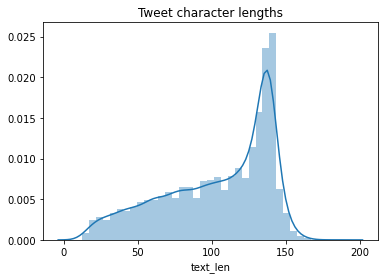

In [12]:
sns.distplot(df.text_len).set_title('Tweet character lengths');

The plot shows a common distribution of twitter datasets. Due to the character limit there is a natural cutoff. Many tweets will have a length close to that maximum since it's hard to reach it exactly. There are also some very short tweets that it's worth zooming into.

In [13]:
df[df.text_len < 30].head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_len
14,570285904809598977,positive,1.0000,NaN,NaN,Virgin America,NaN,sjespers,NaN,0,@VirginAmerica Thanks!,NaN,2015-02-24 10:15:29 -0800,"San Francisco, CA",Pacific Time (US & Canada),22
138,569620102389350401,positive,0.7011,NaN,NaN,Virgin America,NaN,HollywoodHotMom,NaN,0,@VirginAmerica always!!! Xoxo,NaN,2015-02-22 14:09:50 -0800,All Over!,Pacific Time (US & Canada),29
192,569303931916038144,negative,1.0000,Can't Tell,1.0,Virgin America,NaN,MarwaYousofzoy,NaN,0,@VirginAmerica you suck!,NaN,2015-02-21 17:13:29 -0800,NaN,NaN,24


Since short text don't contain much information it can be hard for machine learning models to correctly classify them. However, we want to use the model in production to classfiy *all* incoming tweets, the model also needs to be trained on very short tweets and they cannot be dropped.

Now, let's start looking into the other columns in the dataset. Many columns are meta-data about each tweet - such as Tweet ID, Twitter name, Number of retweets, location etc. - that are either not likely to contribute any predictive power or could lead to the model learning relationships we do not want it to learn. E.g. we wouldn't want to learn a relationship between certain locations and sentiment but make the prediction solely from main input field - the tweet itself.

In [14]:
df.columns.values

array(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'text_len'], dtype=object)

There is another sentiment column in the dataset - `airline_sentiment_gold` - that should be looked at. If the labels in this column are the same as in `airline_sentiment` it can be ignored.

In [34]:
print(f'Check if airline sentiment and airline sentiment gold are the same: {all(df[df.airline_sentiment_gold.notnull()].airline_sentiment_gold == df[df.airline_sentiment_gold.notnull()].airline_sentiment)}')

Check if airline sentiment and airline sentiment gold are the same: True


There are also a few columns that could potentially help a classifier by providing additional information, such as negative reason.

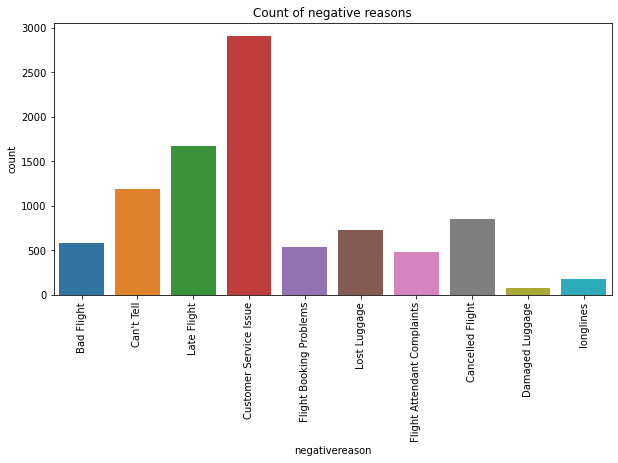

In [15]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=df[df.negativereason.notnull()],
    x='negativereason'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title('Count of negative reasons');

In [16]:
for c in df.airline_sentiment.unique() :
    print(f"Out of {len(df[df.airline_sentiment == c])} {c} tweets {df[df.airline_sentiment == c].negativereason.notnull().sum()} have a negative reason")

Out of 3099 neutral tweets 0 have a negative reason
Out of 2363 positive tweets 0 have a negative reason
Out of 9178 negative tweets 9178 have a negative reason


It looks like there could be valuable information, but this additional information should not be used since *only negative tweets have a negative reason*. Hence, the classifier could simply learn that if any of these reasons show up in the concatenated text, the post will be classified as negative - regardless of the actual content of the tweet. This problem is called **data leakage** and should be avoided at all cost. This is especially important since there is no information about the workflow in which the classifier will be used in production. It could be that negative reasons are assigned manually *after* the sentiment is determined. In this case the information wouldn't even be available at inference time.

Finally, let's have a look at the individual airlines

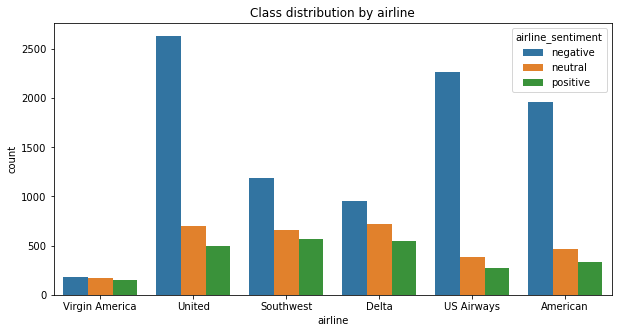

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='airline', hue='airline_sentiment', data=df, hue_order=['negative','neutral','positive']).set_title('Class distribution by airline');

From the plot it looks like United, US Airways and American perform the worst in terms of passenger sentiment. Southwest and Delta have a much lower number of negative tweets relative to neutral and positive tweets. Virgin America has the best ratio with only slightly more negative than neutral or positive tweets but also has the lowest number of tweets overall.

In [18]:
df[['text', 'airline']].sample(10)

,text,airline
8747,@JetBlue bag is supposedly here in Boston,Delta
6801,“@JetBlue: Our fleet's on fleek. http://t.co/b5ttno68xu” I just 🙈,Delta
6118,@SouthwestAir it keeps saying that mobile boarding passes are unavailable despite having checked in and everything,Southwest
9757,@USAirways is holding my luggage hostage from flight 5182,US Airways
4960,@SouthwestAir ridiculous how you want to charge me $209 to change flights even with multiple seats available on the flight I needed,Southwest
10917,@USAirways now the plane is 100 degrees and we are burning up. This is completely illegal.,US Airways
1226,"@united thanks for the link, now finally arrived in Brussels, 9 h after schedule...",United
1007,@united my flight was delayed due to maintenance in LIT and caused me to miss my connection at IAH to MSY. Can you help?,United
8155,@JetBlue needs to get its act together in #PHX,Delta
10714,@USAirways This is the last time I use your airline. I promise that!,US Airways


Usually tweets include the airline name, but sometimes in somewhat different forms. American and Southwest are very often referred to as @AmericanAir or @SouthwestAir and Delta is many times referred to as @JetBlue. I will clean up some of these name differences in the next section.

### Pre-processing

First, I create a new column to also keep the original texts. Then, I add the airline name to all texts that do not include the corresponding value from the airline column. This should cover the @JetBlue case and any other case where the airline mentioned in the text is different or missing entirely. 

In [19]:
df['text_new'] = df['text']

In [20]:
for i in range(len(df)):
    if not df.loc[i,'airline'].replace(' ','').lower() in df.loc[i,'text'].replace(' ','').lower():
        df.loc[i,'text_new'] = '@' + df.loc[i,'airline'] + ' ' + df.loc[i,'text_new']

In [21]:
df.rename(columns={'text':'text_old', 'text_new':'text'}, inplace=True)

Then I will replace three different spelling version of @AmericanAir and @SouthwestAir with the corresponding value from the airline column. Note that one could spend a lot more time on text cleaning like this, but a few simple rules that cover most cases usually will do the job.

In [22]:
idx = df[df.airline == 'American'].index
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@AmericanAir', '@American'))
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@Americanair', '@American'))
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@americanair', '@American'))

In [23]:
idx = df[df.airline == 'Southwest'].index
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@SouthwestAir', '@Southwest'))
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@Southwestair', '@Southwest'))
df.loc[idx, 'text'] = df.loc[idx, 'text'].apply(lambda x: x.replace('@southwestair', '@Southwest'))

Now comes the amazing part of using fastai. All other necessary steps of getting the raw text data into a format that machine learning models can process is done automatically by fastai. It is also worth mentioning that in the new era of using deep learning for NLP, the need for pre-processing text has been greatly reduced. Before deep learning, many pre-processing steps needed to be applied, such as removing stopwords and punctuation or text normlization (e.g. lemmatization or stemming). It turns out that deep learning models can handle the complexities of human language suprisingly well and *removing information from the data can actually hurt model performance*. 

I will quickly demonstrate what fastai does behind the scenes.

In [24]:
defaults.text_proc_rules

[<function fastai2.text.core.fix_html(x)>,
 <function fastai2.text.core.replace_rep(t)>,
 <function fastai2.text.core.replace_wrep(t)>,
 <function fastai2.text.core.spec_add_spaces(t)>,
 <function fastai2.text.core.rm_useless_spaces(t)>,
 <function fastai2.text.core.replace_all_caps(t)>,
 <function fastai2.text.core.replace_maj(t)>,
 <function fastai2.text.core.lowercase(t, add_bos=True, add_eos=False)>]

The above list shows all functions that fastai applies for text pre-processing. I will not go into detail of each rule but one great example is that fastai does lowercasing while maintaining the information that the initial character of a word or the whole word was in capital letters by adding special tokens such as `xxmaj` or `xxup`, respectively. It also adds a `xxbos` token to clearly mark the beginning of each document.

The default tokenizer in fastai is based on a word-based [spaCy](https://spacy.io/) tokenizer and works like this.

In [25]:
spacy = WordTokenizer()
tkn = Tokenizer(spacy)

In [26]:
txt = df['text'][5]
txt

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [27]:
print(coll_repr(tkn(df['text'][5]), 50))

(#30) ['xxbos','@virginamerica','seriously','would','pay','$','30','a','flight','for','seats','that','did',"n't",'have','this','playing','.','\n','it',"'s",'really','the','only','bad','thing','about','flying','xxup','va'...]


I also experimented with sub-word tokenization using `SentencePieceTokenizer` but it performed slightly worse than standard word-based tokenization.

The last step fastai carries out in the pre-processing pipeline is numericalization, i.e. creating a vocabulary and assigning each token to a token id, but I won't go into the details here.

### Training-validation split

In order to evaluate my model on unseen data, I need to create a separate validation set. First, I shuffle the dataframe and then I assign 80% to training and 20% to validation set by creating a new column. Because I am experimenting with different modeling approaches it is very important to have a fixed validation set and not to randomly select a different validation set at each run/for each approach in order to ensure comparability.

In [28]:
df = df.sample(frac=1).reset_index(drop=True)

In [29]:
df['is_valid'] = None
df.loc[:int(0.8*len(df)), 'is_valid'] = False
df.loc[int(0.8*len(df)):, 'is_valid'] = True

In [30]:
len(df[df.is_valid==False])/len(df), len(df[df.is_valid==True])/len(df)

(0.8, 0.2)

In [55]:
df.to_csv(path/'Tweets_valid.csv', index=False)

### Data augmentation and rebalancing

After looking at the dataset, it is clear that it comes with two common disadvantages. First, it is relatively small and second, the class distribution is highly imbalanced. This is problematic for machine learning models, since they could learn to predict only/mainly the dominant class which can result in a good loss but the model wouldn't actually have learned anything valuable from the data.

To solve these issues, I rebalance the dataset using **back-translation for text classification** as in the paper [Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848) by Xie at al. I implemented back-translation using the recently released Neural Machine Translation models from [Helsinki NLP](https://blogs.helsinki.fi/language-technology/) on the [huggingface model hub](https://huggingface.co/models) in a [separate notebook](https://github.com/stefan-jo/USAirlineSent/blob/master/tweets_Data-Aug.ipynb) that I also uploaded on Github. Back-translation is a valid form of data augmentation for NLP since it preserves the overall semantics of the original text while slightly altering the wording. I applied back-translation by first translating the entire training set to German and back to English and then translating the remaining gaps in the class distribution to French and back to English.

I'm now loading the augmented dataset.

In [15]:
df = pd.read_csv('Tweets_final_aug.csv', low_memory=False)

In [16]:
print(f'Increased overall dataset size from {len(df[df.translated==False])} to {len(df)} examples')

Increased overall dataset size from 14640 to 35104 examples


In [17]:
df.duplicated(subset=['text']).sum() / len(df)

0.07030537830446673

It seems like the data augmentation is working as intended, since only 7% of all text are duplicates.

For language modelling I will use all 35104 examples. However, for classification I will not use the translated negative examples since I want to achieve an even class distribution.

In [18]:
df_train = df[df.is_valid == False]
df_valid = df[df.is_valid == True]

In [19]:
df_train = pd.concat([df_train[(df_train.airline_sentiment == 'negative') & (df_train.translated == False)], 
                     df_train[df_train.airline_sentiment != 'negative']])

In [20]:
df_cls = pd.concat([df_train, df_valid[df_valid.translated==False]]).reset_index(drop=True)

In [24]:
df_cls.to_csv('Tweets_cls.csv', index=False)

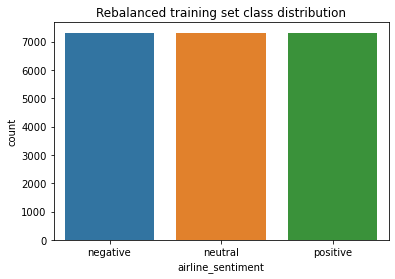

In [22]:
sns.countplot(x='airline_sentiment', data=df_cls[df_cls.is_valid==False], order=['negative','neutral','positive']).set_title('Rebalanced training set class distribution');

For the validation set I keep the original imbalanced class distribution, since that is the distribution that the model most likely will encounter in production. Therefore, evaluating on an imbalanced distribution will yield the most realistic performance evaluation.

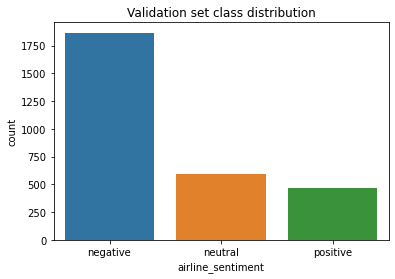

In [23]:
sns.countplot(x='airline_sentiment', data=df_cls[df_cls.is_valid==True], order=['negative','neutral','positive']).set_title('Validation set class distribution');

## 2. Language model fine-tuning

### Model description

ULMFiT can be understood as a transfer learning process that leverages the power of semi-supervised learning for text classification. It was a landmark paper since it introduced the idea of fine-tuning entire deep learning models in NLP instead of just word embeddings - a concept that has already been best practice in computer vision since several years. 

The main steps in the ULMFiT training process are:
1. Pre-train a language model on a large corpus of unlabeled text (e.g. Wikitext 103)
2. Fine-tune the pre-trained language model on a unlabeled target corpus (e.g. in the image below IMDb, in our case Twitter US Airline sentiment)
3. Add a classification head on top of the encoder part of the fine-tuned language model and fine-tune the classifier on labeled examples

<img src="ulmfit_approach.png" width="600" />

This technique allows to effectively leverage the power of semi-supervised language model pre-training. Language modelling is the process of iteratively predicting the next token in a stream of data. This doesn't require any external labels since the labels are built into the training data. The underlying idea is that by being able to solve the hard task of predicting the next word given a sequence of previous words the model needs to learn many features about syntax, semantics and even knowledge about the real world. These learned language representations turned out to be useful for many downstream tasks, such as text classification or named-entity recognition, as well. 

The task for transferring knowledge from language models to classifiers is not trivial. The authors of the ULMFiT paper introduced two methods that make this possible and avoid what is called *catastrophic forgetting*:
1. **Discriminative fine-tuning**: Because earlier layers learn more general features, they should be updated less than the later, more task-specific layers. Instead of applying the same learning rate to all layers, a different learning rate is applied to different layers.
2. **Slated triangular learning rates**: Different learning rates are applied throughout the process of model training. Initially the learning rate starts low out low to warm up and fine-tune the model carefully at the beginning. Then, the learning rate is increased sharply and finally gradually decreased again.
3. **Gradual unfreezing**: The final trick in the ULMFiT toolbox is not to unfreeze all layers at the same time, but to unfreeze the layers one after another, starting at the top and gradually unfreezing more layers before fine-tuning the whole model.

A big decision that must be made is the choice of architecture. The original ULMFiT model was based on an AWD-LSTM, which is a well regularized LSTM-RNN introduced by Merity, Keskar and Socher in [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182). Another option that found success in the multi-lingual [MultiFiT](https://arxiv.org/abs/1909.04761) paper by Eisenschloss et al. is a QRNN architecture introduced by Bradbury et al. in [Quasi-Recurrent Neural Networks](https://arxiv.org/abs/1611.01576). Since the QRNN only has a recurrence mechanism in the pooling layer but doesn't use previous time-steps for calculating the hidden state it trains faster than Recurrent Neural Networks while showing similar performance as LSTMs. 

**Model architecture**

In fastai v2, until now only a 3-layer AWD-LSTM and 4-layer AWD-QRNN are available architectures. However, while the AWD-LSTM has a pre-trained Wikitext 103 model available, this is not yet the case for the AWD-QRNN. I tried pre-training a AWD-QRNN from scratch on the [Sentiment 140 dataset](https://www.kaggle.com/kazanova/sentiment140) with 1.6 million tweets but it didn't surpass the performance of the pre-trained AWD-LSTM model.

In fastai v1, also Transformer and TransformerXL architectures are available. However, the Transformer performed a lot worse than both AWD-LSTM and AWD-QRNN and the TransformerXL model is not a feasible choice, since there are no pre-trained weights available and pre-training from scratch would require a vast amount of data and resources.

### Language Model DataLoaders

Let's finally dive into the modelling itself. I will start by creating a DataLoaders object, which combines training and validation dataloaders, using the DataBlock API. Also, I need to define batch size and sequence lenght for *backpropagation through time*. For language modelling I use a random validation split of 20%.

In [88]:
bs, sl = 128, 80

In [89]:
dblock_lm = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, is_lm=True)),
                      get_x=ColReader('text'),
                      splitter=RandomSplitter(0.2))

In [90]:
dls_lm = dblock_lm.dataloaders(df, bs=bs, seq_len=sl)

In [114]:
print(f'Training set size: {len(dls_lm.train_ds)}')
print(f'Validation set size: {len(dls_lm.valid_ds)}')

Training set size: 28084
Validation set size: 7020


In [93]:
print(f'Vocabulary size: {len(dls_lm.vocab)}')

Vocabulary size: 9264


In [94]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos @southwestair … and how do you get this companion pass ? xxbos @usairways what is the expected wait time to speak to someone via 800 number ? xxbos @american xxmaj i 'm booked for xxmaj tuesday night . 60 degrees in xxmaj xxunk right now . xxmaj i 'm good . xxmaj stay warm and safe . xxbos @usairways @americanair xxmaj thank you for a few easy , hassle - free flights today , professional and friendly staff made","@southwestair … and how do you get this companion pass ? xxbos @usairways what is the expected wait time to speak to someone via 800 number ? xxbos @american xxmaj i 'm booked for xxmaj tuesday night . 60 degrees in xxmaj xxunk right now . xxmaj i 'm good . xxmaj stay warm and safe . xxbos @usairways @americanair xxmaj thank you for a few easy , hassle - free flights today , professional and friendly staff made everything"
1,with a crappy web form that is not made for mobile devices xxbos @delta @jetblue i think it 's safe to say that after 25 years of loyal # jetblue flying we are officially xxup done . # xxmaj xxunk xxbos @southwest @love_dragonss a xxrep 4 h xxup yes xxup lauren xxbos @americanair i just received the ticket . xxmaj thank you for your help xxbos @usairways xxmaj thanks xxmaj kevin and team at xxmaj f38ish at xxup phl for,a crappy web form that is not made for mobile devices xxbos @delta @jetblue i think it 's safe to say that after 25 years of loyal # jetblue flying we are officially xxup done . # xxmaj xxunk xxbos @southwest @love_dragonss a xxrep 4 h xxup yes xxup lauren xxbos @americanair i just received the ticket . xxmaj thank you for your help xxbos @usairways xxmaj thanks xxmaj kevin and team at xxmaj f38ish at xxup phl for some
2,"just silence . xxmaj for hours when we were sitting . xxmaj oh , and then seat was broken . # worst xxbos @southwest xxup amazing c / s today by xxup sw thank you very much . xxmaj that 's why we 're stealing # xxmaj southwest xxbos @usairways your agent did not say xxbos @usairways can not add my frequent flyer number on your website . xxmaj can you help ? xxbos @southwest prove it xxbos @americanair i","silence . xxmaj for hours when we were sitting . xxmaj oh , and then seat was broken . # worst xxbos @southwest xxup amazing c / s today by xxup sw thank you very much . xxmaj that 's why we 're stealing # xxmaj southwest xxbos @usairways your agent did not say xxbos @usairways can not add my frequent flyer number on your website . xxmaj can you help ? xxbos @southwest prove it xxbos @americanair i xxunk"


By looking at the data it becomes clear what the DataBlock API did behind the scences if `is_lm=True` is chosen. The targets are same as the input texts *but shifted by one token to the right*. 

### Forward processing

I now define a `language_model_learner`, which automatically loads the pre-trained Wikitext 103 weights into the AWD-LSTM architecture, selects an appropriate loss function and optimizer, adds momentum and performs other tweaks such as splitting the model into layer groups.

I define the following inputs:
- **Dropout**: rather than tuning each of the many dropout probabilities indiviually, `drop_mult` allows the used to scale all dropout probabilities together, which `drop_mult=1.0` being the default values. In this case, decreasing the amount of regularization improved model performance.
- **Metrics**: Accuracy measures how often the model correctly predicts the next word out of all 9264 words in the vocabulary. Perpexity, which is the exponential of the cross-entropy loss, is a common metric for language modelling. 
- **Mixed-precision callback**: by adding `to_fp16()` the model will use mixed-precision training, which uses half-precision for forward and backward propagation to allow faster training but full-precision for gradient updates to avoid imprecise updates.

In [98]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0691830962896347)

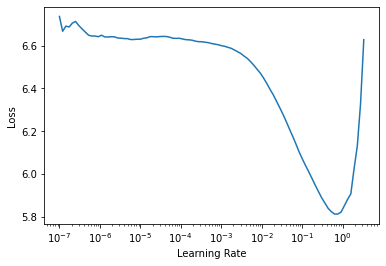

In [99]:
learn.lr_find()

The learning rate can be chosen using fastai's conveniant **learning rate finder**, which starts training the model with an increasing learning rate to find out at which rate the model learns the fastest.

The new fastai v2 method `learn.fine_tune` first trains the frozen language model to only update the embeddings layer, then unfreezes and trains the entire model for 20 epochs. I also set **weight decay** to 0.01 in order to add some more regularization.

In [100]:
learn.fine_tune(20, 7e-2, wd=0.01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.540660,4.011322,0.263410,55.219826,01:37


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.687577,3.546840,0.313441,34.703487,01:43
1,3.524276,3.415937,0.329256,30.445469,01:43
2,3.369646,3.324966,0.337778,27.798046,01:44
3,3.227460,3.252619,0.350674,25.857973,01:43
4,3.071623,3.195496,0.361006,24.422287,01:42
5,2.919820,3.116642,0.376178,22.570450,01:42
6,2.766087,3.047589,0.388247,21.064497,01:42
7,2.607582,2.987858,0.402714,19.843134,01:43
8,2.454636,2.926714,0.417649,18.666191,01:42
9,2.320695,2.878920,0.432567,17.795042,01:44


I'm now saving three files:
- the whole language model, including the language model head
- only the encoder, which is the model body without the language model head
- the DataLoaders which were used for language modeling

In [101]:
learn.save('tweets_lm')

In [102]:
learn.save_encoder('tweets_lm_enc')

In [103]:
output = open('dls_lm.pkl', 'wb')
pickle.dump(dls_lm, output)
output.close()

### Backward processing

In addition to standard forward processing, I train another language model that carries out the exact same task, but the texts are fed to it in *reverse order*. 

**Bi-directional training** usually improves model performance, but it is not possible to use bi-directional training for causal or auto-regressive language modelling, because the model would be able to see the word it tries to predict from the other side, respectively. One way for allowing bi-directionality in auto-regressive language models is to simply train separate language models for forward and backward processing, then fine-tuning separate classifiers on top of these and finally ensembling the predictions.

The idea for forward and backward training is taken from this [notebook](https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb) which shows how Jeremy Howard and Sylvain Gugger set a new benchmark on the IMDb sentiment classification task with an accuracy of 95.4%.

In [116]:
pkl_file = open('dls_lm.pkl', 'rb')
dls_lm_bwd = pickle.load(pkl_file)
pkl_file.close()

Adding a transform that reverses the tokens

In [117]:
dls_lm_bwd.tfms.add(Transform(lambda nums: nums.flip(0)))

In [118]:
dls_lm_bwd.show_batch(max_n=3)

,text,text_
0,"! xxunk worst my for that want n't would i ! ever hotel worst the for night per 79 $ ! bs xxup are vouchers hotel "" complimentary "" your xxmaj @southwestair xxbos xxunk xxmaj . plane the to walk the along xxunk different three to @combines xxbos ! lax xxup at number l&&f xxup answering one no xxmaj . 2a seat xxmaj . today lax xxup to iad xxup 89 flight on headphones expensive left , help @virginamerica xxbos","xxunk worst my for that want n't would i ! ever hotel worst the for night per 79 $ ! bs xxup are vouchers hotel "" complimentary "" your xxmaj @southwestair xxbos xxunk xxmaj . plane the to walk the along xxunk different three to @combines xxbos ! lax xxup at number l&&f xxup answering one no xxmaj . 2a seat xxmaj . today lax xxup to iad xxup 89 flight on headphones expensive left , help @virginamerica xxbos xxunk"
1,@americanair would earth on why xxmaj . worst the is @usairways xxbos ? xxunk # a that was xxmaj . flights airlines xxmaj united xxmaj # all on impact great - systemwide # below apparently system xxmaj xxunk xxmaj load xxmaj @united xxbos ! u thank xxmaj . lax to atl and atl xxmaj to cun xxup from and cun xxmaj to den from xxmaj ! stewardesses sw xxup your by service amazing @southwest xxbos . hours 2 wait should,would earth on why xxmaj . worst the is @usairways xxbos ? xxunk # a that was xxmaj . flights airlines xxmaj united xxmaj # all on impact great - systemwide # below apparently system xxmaj xxunk xxmaj load xxmaj @united xxbos ! u thank xxmaj . lax to atl and atl xxmaj to cun xxup from and cun xxmaj to den from xxmaj ! stewardesses sw xxup your by service amazing @southwest xxbos . hours 2 wait should we
2,talk & & service xxmaj customer xxmaj in call i today so xxmaj @southwestair xxbos impossible is relations customer of hold a get to trying even . flights on credits using for process backwards ass most the has @usairways xxbos father my as in checked was i bc flight original my off taken was i after only but memphis xxmaj to flight a given eventually was i @usairways xxbos num demand u ed dm xxup @united xxbos 200 $ you,& & service xxmaj customer xxmaj in call i today so xxmaj @southwestair xxbos impossible is relations customer of hold a get to trying even . flights on credits using for process backwards ass most the has @usairways xxbos father my as in checked was i bc flight original my off taken was i after only but memphis xxmaj to flight a given eventually was i @usairways xxbos num demand u ed dm xxup @united xxbos 200 $ you change


In [119]:
learn = language_model_learner(dls_lm_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.04786301031708717)

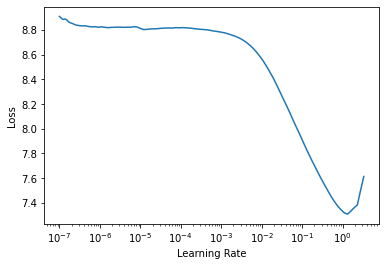

In [108]:
learn.lr_find()

In [120]:
learn.fine_tune(20, 5e-2, wd=0.01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.566859,4.464024,0.275772,86.836243,01:57


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.223659,4.021893,0.317948,55.806622,02:02
1,4.028666,3.832830,0.335267,46.193089,02:01
2,3.848314,3.679535,0.344750,39.627979,02:02
3,3.645606,3.555409,0.360605,35.002121,02:00
4,3.458896,3.466792,0.372948,32.033817,02:00
5,3.282411,3.355469,0.388020,28.659035,02:01
6,3.105316,3.269194,0.402850,26.290133,02:00
7,2.956610,3.208920,0.414778,24.752352,02:01
8,2.797982,3.138691,0.426518,23.073643,01:59
9,2.657143,3.079076,0.437575,21.738302,02:01


In [121]:
learn.save('tweets_lm_bwd')

In [122]:
learn.save_encoder('tweets_lm_enc_bwd')

## 3. Sentiment classifier

Equipped with both a fine-tuned forward and backward language model I now turn to the task of interest - *classifying the sentiment of tweets from US Airline passengers*. Since I already described the ULMFiT training process above I will directly get to it.

### Classification DataLoaders

In [25]:
bs, sl = 128, 80

Loading the classification dataframe that does not include translations for negative training examples and validation set. I also need to load the language model DataLoaders from before.

In [48]:
df_cls = pd.read_csv('Tweets_cls.csv')

In [27]:
pkl_file = open('dls_lm.pkl', 'rb')
dls_lm = pickle.load(pkl_file)
pkl_file.close()

After creating the classification DataLoaders for the first time I realized that there are some reviews in the dataset that only contain the character '#' repeated many times. Let's get rid of those reviews.

In [86]:
invalid = []
for i in range(len(df_cls)):
    if '# #' in df_cls.text[i]:
        invalid.append(i)

In [87]:
invalid

[4388, 4488]

In [89]:
df_cls.text[invalid]

4388    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ...
4488    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [90]:
df_cls = df_cls.drop(index = invalid).reset_index(drop=True)

It's absolutely crucial to pass the vocabulary from the DataLoaders used for language model fine-tuning to the DataBlock API when creating the classification DataLoaders. Otherwise we would end up with an entirely different mapping from indices to tokens. 

The other differences to the language model DataLoaders are:
- Use of `CategoryBlock` instead of `is_lm=True` to tell the DataBlock API that we have a classification problem
- Define in which column the labels are stored (`airline_sentiment`) since we no longer have a semi-supervised but a supervised setting
- Use the fixed validation set defined above (`is_valid`) instead of a random split

In [95]:
dblock = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, vocab=dls_lm.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('airline_sentiment'),
                      splitter=ColSplitter('is_valid'))

In [96]:
dls_cls = dblock.dataloaders(df_cls, bs=bs, seq_len=sl)

In [116]:
print(f'Training set size: {len(dls_cls.train_ds)}')
print(f'Validation set size: {len(dls_cls.valid_ds)}')

Training set size: 21934
Validation set size: 2928


In [117]:
print(f'Vocabulary size: {len(dls_cls.vocab[0])}')

Vocabulary size: 9264


In [118]:
assert len(dls_lm.vocab) == len(dls_cls.vocab[0])

The vocabulary of language model and classification DataLoaders should be the same since the classification dataset is a subset of the whole dataset which was used for language modelling. 

Let's print the different classes, look at the data and save the classification DataLoaders

In [119]:
dls_cls.vocab[1]

(#3) ['negative','neutral','positive']

In [122]:
dls_cls.show_batch(max_n=5)

,text,category
0,xxbos @usairways @americanair xxmaj xxunk xxmaj xxunk along the way ! ! … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … … …,positive
1,xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever xxrep 3 ! xxup thank u xxup so xxup much xxrep 6 !,positive
2,xxbos @united xxmaj hello have a question re future flight booking problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . i am * g. xxmaj what is abandoned bag allowance for xxup jac - lax ?,neutral
3,xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup permission ! ! # xxup ph6rps,negative
4,"xxbos @delta @jetblue xxmaj thanks . xxmaj always booked our trip 3 / 13 - 17 xxup lb to xxup slc to see the big kids . xxmaj only very frustrating . xxmaj tryed app , web , etc . xxmaj always love guys u !",positive


In [123]:
output = open('dls_cls.pkl', 'wb')
pickle.dump(dls_cls, output)
output.close()

### Forward processing

Similar as before, I now define a `text_classifier_learner` that automatically selects optimizer etc., but also adds a classification head based on the number of classes that is stored in `dls_cls`. 

Since the validation set is an imbalanced dataset with 3 classes, accuracy as a single metric can be misleading. If the classifier learns to only predict the dominant class it could still achieve a decent level of accuracy while not learning anything at all. A common metric for imbalanced prediction problems is F1 Score. More specifically, I selected a macro average because a weighted average could again favor the prediction of the most common class.

In addition, I use **label smoothing cross entropy** as loss function for the text classifier. Instead of a one-hot encoded target vector, label smoothing assigns a high probability to the correct target, and very small probabilities to all other targets. This turned out to be a useful technique to cope with noisy labels as it makes the classifier *less confident*. Especially for sentiment classification datasets, where the labelling task of assigning sentiment to a piece of text can be highly subjective to the person who annotates the data, noisy labels are not uncommon.

In [178]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,F1Score(average='macro')],
                               loss_func=LabelSmoothingCrossEntropy()).to_fp16()

Here I am loading the encoder part of the fine-tuned language model that I saved before.

In [179]:
learn.load_encoder('tweets_lm_enc');

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.001737800776027143)

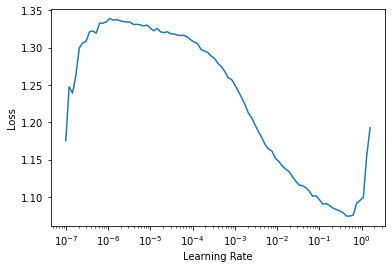

In [126]:
learn.lr_find()

Even though the learning rate finder would suggest to pick a learning rate around 2e-3 where the slope is the steepest, I found that a higher learning rate, specifically 2e-1 which is much closer to the minimum, leads to a nicer training behavior and ultimately also a better performance.

The classification model with pre-trained encoder is fine-tuned using *gradual unfreezing* as described above. First, only the randomly initialized classification head is trained, then more and more layers are being unfrozen one at a time until the entire model is being updated.

In [180]:
lr, n_epoch, wd = 2e-1, 1, 0.01
learn.fit_one_cycle(n_epoch, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.924312,0.764413,0.731216,0.679407,00:10


In [181]:
learn.freeze_to(-2)
learn.fit_one_cycle(n_epoch, slice((lr/2)/(2.6**4),lr/2), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.681368,0.702460,0.784495,0.733351,00:12


In [182]:
learn.freeze_to(-3)
learn.fit_one_cycle(n_epoch, slice((lr/4)/(2.6**4),lr/4), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.582381,0.668032,0.795424,0.733890,00:15


In [183]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch*4, slice((lr/10)/(2.6**4),lr/10), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.508491,0.706080,0.784495,0.741091,00:17
1,0.457943,0.687196,0.804986,0.751230,00:18
2,0.406332,0.660119,0.811134,0.754131,00:18
3,0.384192,0.658847,0.815574,0.754708,00:18


Let's have a look what's happening during training by plotting losses, learning rate and momentum.

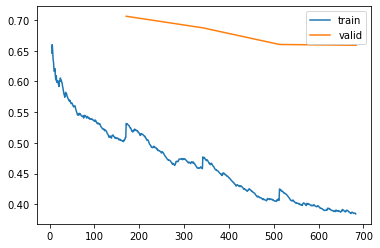

In [184]:
learn.recorder.plot_loss()

From the plot above it can be seen that both training and validation loss are decreasing nicely during training. The validation loss remains at a higher level and starts to flatten out towards the last iterations which is an indication that the model has been trained sufficiently, yet didn't start to overfit. Anyway, following Jeremy Howard's advice, as long as our metric of interest - here the F1 Score - is not getting worse, everything is fine.

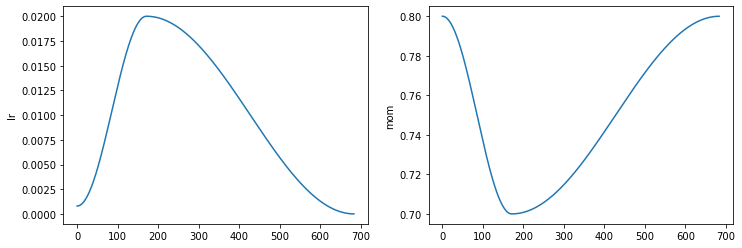

In [185]:
learn.recorder.plot_sched()

The above plots demonstrate the **one-cycle training policy**. As already described above, the learning rate is low at the beginning, then increases sharply and is gradually reduced again. The momentum is scheduled in exactly the opposite way, starting high, dropping sharply and gradually increasing again. The logic behind this is that if you have a small learning rate and make careful updates, but you are going in the right direction for a while, the model can take larger steps and learn faster. If the learning rate is large on the other hand, momentum is lower to reduce the risk of making too large steps in the wrong direction.

Saving the model for ensembling and inference

In [186]:
learn.save('tweets_clf')

### Backward processing

Now I'm applying the same steps of fine-tuning a classifier from a pre-trained language model as above, but again with the tokens in reverse order. Everything else is exactly the same.

In [207]:
pkl_file = open('dls_cls.pkl', 'rb')
dls_cls_bwd = pickle.load(pkl_file)
pkl_file.close()

Priting out the transformations that are stored with the classification DataLoaders

In [390]:
dls_cls_bwd.tfms[0], dls_cls_bwd.tfms[1]

(Pipeline: ColReader -> Tokenizer -> Numericalize -> <lambda>,
 Pipeline: ColReader -> Categorize)

Adding the reverse transformation only to the text column

In [209]:
dls_cls_bwd.tfms[0].add(Transform(lambda nums: nums.flip(0)))

In [344]:
learn_bwd = text_classifier_learner(dls_cls_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,F1Score(average='macro')],
                               loss_func=LabelSmoothingCrossEntropy()).to_fp16()

In [345]:
learn_bwd.load_encoder('tweets_lm_enc_bwd');

In [346]:
lr, n_epoch, wd = 2e-1, 1, 0.01
learn_bwd.fit_one_cycle(n_epoch, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.939930,0.767722,0.729167,0.645511,00:09


In [347]:
learn_bwd.freeze_to(-2)
learn_bwd.fit_one_cycle(n_epoch, slice((lr/2)/(2.6**4),lr/2), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.709978,0.675881,0.785178,0.723093,00:10


In [348]:
learn_bwd.freeze_to(-3)
learn_bwd.fit_one_cycle(n_epoch, slice((lr/4)/(2.6**4),lr/4), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.604315,0.673532,0.791325,0.734232,00:13


In [349]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(n_epoch*2, slice((lr/20)/(2.6**4),lr/20), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.516660,0.689407,0.788934,0.737093,00:17
1,0.460267,0.687917,0.800205,0.744531,00:17


In [350]:
learn.save('tweets_clf_bwd')

### Ensembling

Finally I will ensemble the predictions from both the forward and the backward classifier and see if it improves performance. For model evaluation I import `f1_score` and `classification_report` from scikit-learn.

In [382]:
from sklearn.metrics import f1_score, classification_report

Retrieving validation set predictions and labels for the forward classifier

In [362]:
pred_fwd,lbl_fwd = learn.get_preds()

In [363]:
print(f'Forward accuracy: {round(accuracy(pred_fwd, lbl_fwd).numpy().item(),4)}')
print(f"Forward F1 score: {round(f1_score(lbl_fwd, pred_fwd.argmax(-1), average='macro'),4)}")

Forward accuracy: 0.8156
Forward F1 score: 0.7547


Doing the same for the backward classifier

In [364]:
pred_bwd,lbl_bwd = learn_bwd.get_preds()

In [365]:
print(f'Backward accuracy: {round(accuracy(pred_bwd, lbl_fwd).numpy().item(),4)}')
print(f"Backward F1 score: {round(f1_score(lbl_fwd, pred_bwd.argmax(-1), average='macro'),4)}")

Backward accuracy: 0.8002
Backward F1 score: 0.7445


And finally I'm ensembling the predictions from both models by simply averaging them. Note that calculating a weighted average with the better performing forward model being weighted twice as much as the backward model results in an even higher score.

In [370]:
final_pred = (pred_fwd*2 + pred_bwd) / 3

In [371]:
print(f'Forward and backward accuracy: {round(accuracy(final_pred, lbl_fwd).numpy().item(),4)}')
print(f"Forward and backward F1 score: {round(f1_score(lbl_fwd, final_pred.argmax(-1), average='macro'),4)}")

Forward and backward accuracy: 0.8221
Forward and backward F1 score: 0.7637


In [384]:
print(classification_report(lbl_fwd, final_pred.argmax(-1)))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1866
           1       0.66      0.60      0.63       590
           2       0.78      0.76      0.77       472

    accuracy                           0.82      2928
   macro avg       0.77      0.76      0.76      2928
weighted avg       0.82      0.82      0.82      2928



In [385]:
dls_cls.vocab[1]

(#3) ['negative','neutral','positive']

To sum up the results:
- The forward classier performs better than the backward classifier both in terms of accuracy and F1 score. 
- The ensembled predictions achieve an even higher score, however the gain is relatively small. My assumption for this is that the errors from both classifiers are strongly correlated, i.e. they make the same mistakes
- Accuracy would also have been a meaningful performance metric here since it is well correlated with F1 score.
- Looking at the recall scores in the detailed classification report, it can be seen that the model predicts 91% of all negative labels correcty, 76% of all positive labels and only 60% of all neutral labels. 
- Precision scores - i.e. how many of all predicted examples in one class actually were that class - behave similarly, however with neutral and positive examples turning out slightly better relative to negative ones.

I would evaluate the overall model performance as rather good. The model performs very well on negative examples, which in a production use case should contain the most relevant information since it can help airlines improve customer satisfaction. The performance on positive examples should also be sufficiently good for practical use. This can help airlines to find out what they are doing right and should not be changing. The lowest scores were achieved for neutral examples, which is not surprising since neutrals border both with negatives and positives and could more easily be confused. However, if the most important trends in the data can be discovered from the negative and positive examples the lower performance on neutral tweets could be acceptable. In many academic sentiment classification datasets, e.g. also in the IMDb movie reviews dataset, neutral reviews are entirely excluded, what makes it for the classifier obviously much easier to achieve a higher performance in terms of accuracy.

### Error analysis

Let's now look into the errors the model makes in more detail by printing out some of the fastai interpretation methods. Note that I only run model interpretation on the higher scoring forward model, assuming that the backward model will show similar results.

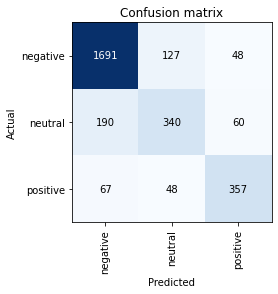

In [386]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [387]:
interp.most_confused()

[('neutral', 'negative', 190),
 ('negative', 'neutral', 127),
 ('positive', 'negative', 67),
 ('neutral', 'positive', 60),
 ('negative', 'positive', 48),
 ('positive', 'neutral', 48)]

It can be seen in both confusion matrix and most confused classes, that the model mostly confuses neutral and negative examples which nevertheless should be interpreted carefully, since there are also many more negative than positive examples in the validation set. Surprisingly the model confuses negative and positive examples more often than neutral and positive examples. The reason behind this could be tweets containing subtle irony.

In [388]:
interp.plot_top_losses(k=10)

,input,target,predicted,probability,loss
0,"xxbos @delta @jetblue what are the chances of actually flying out of xxmaj charleston today ? ? xxmaj cold , xxunk weather in the south of all places …",positive,neutral,0.9897045493125916,5.151103496551514
1,xxbos @southwestair @fortunemagazine xxmaj congratulations !,neutral,positive,0.9116714596748352,4.337149620056152
2,xxbos @delta @jetblue 's xxup ceo battles to appease passengers and xxmaj wall xxmaj street - xxmaj waterbury xxmaj republican xxmaj american http : / / t.co / xxunk,negative,neutral,0.9473183155059814,4.334376811981201
3,"xxbos @americanair xxmaj is it possible to change the xxup ff number on a passenger on a xxmaj flight xxmaj booking xxmaj problems , it wo n't let me change it ?",negative,neutral,0.9649021029472351,4.257993698120117
4,xxbos @southwestair save mile to visit family in 2015 and this will impact how many times i can see my mother . i planned and you change the rules,positive,neutral,0.9665367007255554,4.230259895324707
5,xxbos @delta xxmaj lmfa xxrep 3 o “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ”,positive,negative,0.529869556427002,4.140007019042969
6,xxbos @delta @jetblue xxunk xxunk,positive,neutral,0.7724604606628418,4.11350679397583
7,xxbos @southwestair xxmaj how do i stop getting credit card apps ? i already have a card !,negative,neutral,0.9703917503356934,4.051311492919922
8,xxbos @united xxunk xxunk @fioretti2ndward @garcia4chicago xxup faa invest near miss on o'hare runway last wk : http : / / t.co / xxunk,neutral,negative,0.9707198739051819,4.029001235961914
9,xxbos @southwestair xxup betsy is the xxup besty ! xxmaj gettin ' stuck at # xxup las might not be bad for most .. but i want home ! # xxunk # betsy # besty # thankyou,negative,positive,0.6787416338920593,4.02787971496582


Looking at the highest losses above reveils interesting insights about the dataset:
- There are some tweets that I would consider to be mislabeled. E.g. I don't see anything in tweet 0 that would make it positive. Similarly, tweet 4 actually sounds more negative than positive to me. 
- There are some very short tweets or tweets that don't contain much valuable information, such as tweets 5, 6 and 8.
- But there are also cases where the model simply made a mistake, e.g tweets 2, 3, and 7.

In [389]:
interp.plot_top_losses(k=10, largest=False)

,input,target,predicted,probability,loss
0,"xxbos @united boarding was decent , 3 useless agents that do n't speak xxmaj english ( after xxunk of hold ) 6hrs of mech delay not so much",negative,negative,0.9339267015457153,0.2911436855792999
1,"xxbos @americanair pretty impressed with the in flight entertainment . xxmaj full touch , xxunk , smooth , good selection .",positive,positive,0.9328001141548157,0.2911463975906372
2,xxbos @usairways xxmaj cancelled xxmaj flightled due to maintenance . xxmaj the plane was there for 10 hours . xxmaj get your shit together because there are a lot of people unhappy .,negative,negative,0.9338292479515076,0.2911504805088043
3,xxbos @united wanted to point out that not one xxmaj united crew has been sympathetic . xxmaj questions xxunk . mileageplus is starting to look like a joke,negative,negative,0.9343459010124207,0.2911507487297058
4,xxbos @usairways sorry does n't help . xxmaj it 's midnight xxup pst . xxmaj how in the hell am i still on hold after 90 minutes on customer service line ?,negative,negative,0.9343749284744263,0.2911522686481476
5,xxbos @americanair 1hr 46 min . xxmaj cost of flight change $ 788 . xxmaj was $ 188 2hrs ago b / f drop call . xxmaj cancelled xxmaj flighted flight . xxmaj asked 4 refund .,negative,negative,0.9327638149261475,0.291152685880661
6,xxbos @usairways xxmaj seat xxunk on xxmaj flight 545 last night is the worst seat xxmaj i 've ever been in . xxmaj no leg room ! # xxunk http : / / t.co / xxunk,negative,negative,0.9320341348648071,0.2911541759967804
7,"xxbos @usairways your service at xxup phl is abysmal . xxmaj an hour on the runway waiting for a gate , no information anywhere , missed my connection abysmal !",negative,negative,0.9337310194969177,0.29115796089172363
8,xxbos @americanair has to be the worst airline in the world # yousuck # horrible # xxmaj oscars2015,negative,negative,0.9319080710411072,0.29115912318229675
9,xxbos @americanair i did . 5 times . xxmaj with 4 of those being hung up on . xxmaj the other one it finally sent me to the call back notification . # xxunk,negative,negative,0.934791624546051,0.2911621928215027


Looking the lowest losses, or in other words where the model confidently predicted the correct class, shows no surprises. Apart from one positive example, all other 9 tweets are negative and all tweets contain sufficient information and are clearly formulated which makes it easy for the classifier.

## Conclusion

In this notebook I trained a ULMFiT model on the US Airline Twitter Sentiment dataset leveraging the power of semi-supervised language model pre-training and fine-tuning. The model performed very well on the task at hand, achieving an accuracy of 82% and a F1 score of 76%. Performance was best for negative examples and worst for neutral examples. Even though ensembling a forward and backward model resulted in a slightly higher accuracy and F1 score, which could make a difference in data science competitions, the performance gains relative to the additional effort would make me choose the forward classifier over ensembling for deploying the classifier to production systems. 

There has been a lot of progress in NLP since the publication of the ULMFiT paper, specifically with large pre-trained transformer models, but ULMFiT is still be very powerful and efficient method for text classification. This is especially the case when only a small labelled dataset but a large corpus of unlabelled domain-specific documents are available as in many industry settings. 

In order to further improve the model, one could:
- spend more time on data cleaning and pre-processing, e.g. identifying and correcting mislabelled examples
- expand the twitter corpus for language model fine-tuning with more unlabelled data
- fine-tune a large state-of-the-art transformer model, such as BERT, RoBERTa or XLNet

All training was performed on a P5000 GPU using paperspace except back-translation which was done on a P100 GPU on GCP.